# Fully Connected Network and MNIST

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Ben Sattelberg and Asa Ben-Hur with updates by Ross Beveridge.

Last Update 11/11/20201

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## About Keras

This notebook uses [Keras](https://keras.io) and so you may need to add Keras to your available packages.

I am using Conda to manage my Python setup and here so use these [Instructions](https://anaconda.org/conda-forge/keras)

And a note about suppressing warnings.  Normally I hate to do this, but there modern ML APIs get into knots over different versions and dependences and the issue involves compatibility between different versions of TensorFlow relative to versions of Numpy. For the moment (4/8/2021) all is still working - so I don't want to be told about future problems.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras

Using TensorFlow backend.


# Neural Networks

### Preface:  enabling GPUs on google colab

Until now we ran our neural networks on a CPU.  If you are running this notebook on google colab, you are in luck - google colab will allow you to run your code on a GPU.  Enabling a GPU is very simple:  All you need to do is navigate to Edit→Notebook Settings and select GPU from the Hardware Accelerator drop-down.
This [colab notebook](https://colab.research.google.com/notebooks/gpu.ipynb) has instructions for verifying that you are using a GPU and see the resulting speedup.


## The MNIST dataset

In this notebook, we'll look at the real (but still relatively easy) problem of handwritten digit recognition.  We will be using the MNIST (modified National Institute of Standards and Technology) database which has images taken from a NIST database of handwritten digits and modified by Yann Lecun, Corinna Cortes, and Christopher J.C. Burges to be more easily used in machine learning.

You are encouraged to read up more on this dataset. While no longer useful for demonstrating state-of-the-art advancments in machine learning, as a dataset, it will live on for a long time as both a teaching tools (see this lecture) and also some degree as a testbed for ideas aimed at better explaining the behavior of machine learning algorithms. To get you started:

- The basics: [MNIST Database on Wikipedia](https://en.wikipedia.org/wiki/MNIST_database)
- A significant read: [A Survey of Handwritten Character Recognition with MNIST and EMNIST](https://www.mdpi.com/2076-3417/9/15/3169)

No on to today's excericse. The first thing we need to do is to load the dataset.  Fortunately, Keras does this work for us:

In [3]:
# This will download an 11.5 MB file to ~/.keras/datasets/
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Let's get some information about the dataset:

In [4]:
print(X_train.shape, y_train.shape)
print(min(y_train), max(y_train))

(60000, 28, 28) (60000,)
0 9


This tells that we have 60,000 input images, each of which is 28x28 pixels.  The labels are, unsuprisingly for a database of digits, the numbers 0 through 9, corresponding to which digit the image represents.  Now let's look at the test set:

In [5]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


Here we have 10,000 samples with the same format as the training set.

Let's look at one of the images:

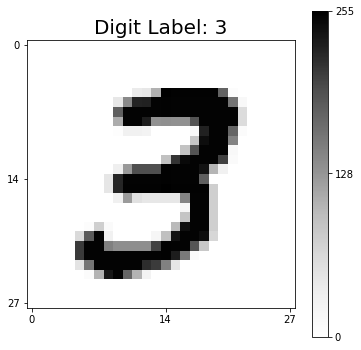

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
pick = 7
im = ax.imshow(X_train[pick, :, :], cmap='Greys')
ax.set_title("Digit Label: " + str(y_train[pick]),fontsize=20)
cbar = fig.colorbar(im)
cbar.set_ticks([0, 128, 255])
ax.set_xticks([0, 14, 27])
ax.set_yticks([0, 14, 27]);

Here we can see that the image is a grayscale 28x28 image with pixel values between 0 and 255.  We can also look at a few other images in the dataset:

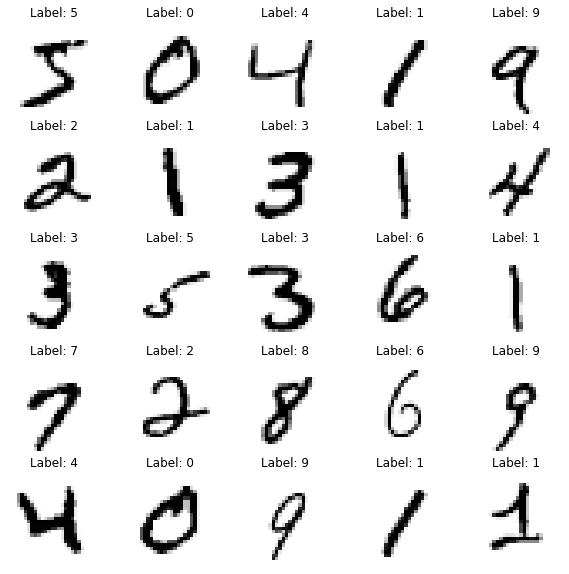

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))

for i in range(5):
    for j in range(5):
        axes[i,j].imshow(X_train[i*5 + j, :, :], cmap='Greys')
        axes[i,j].set_title("Label: " + str(y_train[i*5+j]))
        axes[i,j].axis('off')

There are a few things we want to do to the input data before we use it.  The first is to convert it to 32 bit floats:

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

We also want to change the range of the data from integers between 0 and 255 to numbers between 0 and 1 to help with training:

In [9]:
X_train /= 255
X_test /= 255

The last step, which is less obvious, is to reshape the actual data to have an extra dimension:

In [10]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

This dimension corresponds to the number of "channels" in the image.  This data is grayscale, but color images are typically stored in RGB (red, green, blue) format, where there the three channels describe the amount of red, green, and blue at each pixel.  Keras is designed to handle images as a native data format without needing to "flatten" the images into vectors as a preprocessing step.

We will also convert the `y_train` and `y_test` to a one-hot encoding:

In [11]:
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

We have reviewed one hot encoding several times, but just to keep in clear in everyone's mind, here we print out the original training signal (y vector) and the one hot encoding equivalent.

In [12]:
bnd = 10
for i in range(bnd) :
    foo = [round(x) for x in y_test_one_hot[i]]
    print(f'sample {i}: {y_test[i]}, {foo}')


sample 0: 7, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
sample 1: 2, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
sample 2: 1, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
sample 3: 0, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sample 4: 4, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
sample 5: 1, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
sample 6: 4, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
sample 7: 9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
sample 8: 5, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
sample 9: 9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


### Single hidden layer - Linear Models

The first experiment we will do with this dataset is to test a simple linear model to get a baseline for how good we can expect our models to be.  We will use Keras for this, and simply not have any hidden layers in our network.

In addition to the accuracy on the training set, we want to keep track of the accuracy on the testing set.  One way to do this with Keras is with a callback function that keeps track of the accuracy on the testing set as we progress through it.  It isn't necessary to understand the code here, but it is good to be aware of the goal of this structure.

In [13]:
# Structure based on https://github.com/keras-team/keras/issues/2548
class EvaluateCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        if 'test loss' not in logs:
            logs['test loss'] = []
            logs['test acc'] = []
        logs['test loss'] += [loss]
        logs['test acc'] += [acc]
        print(f'Testing loss: {loss:6.4f}, Testing accuracy: {acc:6.4f}')

We can now train our model.  One layer to notice is the ```Flatten()``` layer.  This layer converts the data from a 28x28x1 dimensional image to a 784=28\*28\*1 dimensional vector.

Also notice the activation argument 'softmax'. Recall from our previous notebook that there are two things notable about using softmax.

- The sum of the activiations, in our case ten output units, after softmax, will be forced to equal 1.0
- Most of the 'mass' will naturally be shifted to the unit withe largest input excitation

To get more background start with the [Wikipedia Softmax function](https://en.wikipedia.org/wiki/Softmax_function) page.

In [17]:
linear_model = keras.Sequential()
linear_model.add(keras.layers.Flatten())
linear_model.add(keras.layers.Dense(10, activation='softmax'))
loss_fn = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

linear_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
linear_history = linear_model.fit(X_train, y_train_one_hot, 
                                  batch_size=100, epochs=20, 
                                  verbose=1, callbacks=[EvaluateCallback((X_test, y_test_one_hot))])

Epoch 1/20
60000/60000 [==============================] - 1s 8us/step - loss: 0.6325 - accuracy: 0.8417
Testing loss: 0.3644, Testing accuracy: 0.9068
Epoch 2/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.3470 - accuracy: 0.9057
Testing loss: 0.3107, Testing accuracy: 0.9143
Epoch 3/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.3102 - accuracy: 0.9139
Testing loss: 0.2893, Testing accuracy: 0.9195
Epoch 4/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.2924 - accuracy: 0.9182
Testing loss: 0.2845, Testing accuracy: 0.9218
Epoch 5/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.2821 - accuracy: 0.9215
Testing loss: 0.2736, Testing accuracy: 0.9229
Epoch 6/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.2749 - accuracy: 0.9239
Testing loss: 0.2726, Testing accuracy: 0.9235
Epoch 7/20
60000/60000 [==============================] - 0s 8us/step - loss: 0.2694 - accurac

In [18]:
def printFinalLossAccuracy(model) :
    loss_acc = model.evaluate(X_test, y_test_one_hot, verbose=0)
    print(f'Final loss {loss_acc[0]:6.4f}, test_accuracy {loss_acc[1]:6.3f}')
    
printFinalLossAccuracy(linear_model)

Final loss 0.2629, test_accuracy  0.927


We can look at the summary of this model - the main thing to note here is the number of parameters:

In [19]:
linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


We can also look at the accuracy over the epochs of the network:

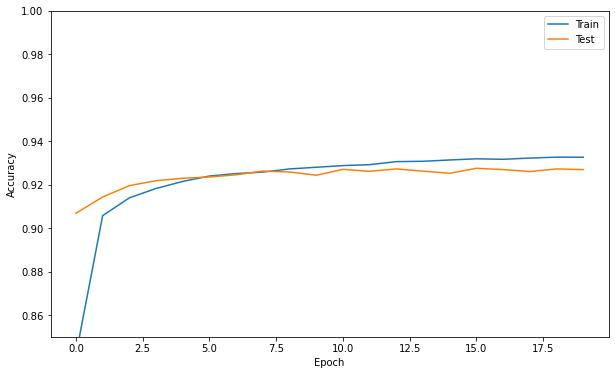

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(linear_history.history['accuracy'], label='Train')
ax.plot(linear_history.history['test acc'], label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_ylim([0.85, 1]);

We can see that even a simple linear classifier gets about 92% accuracy.  MNIST is commonly used as a tutorial dataset, and one of the reasons for that is that basically anything will be successful on it.  The dataset is also solved - methods exist that do better than human accuracy and will reach around 99.9% accuracy (i.e 10 samples out of the 10,000 misclassified).

## A 2 Layer MNIST network

Now we introduce a large - 100 node - hidden layer.  

In [22]:
network = keras.Sequential()
network.add(keras.layers.Flatten())
network.add(keras.layers.Dense(100, activation='relu'))
network.add(keras.layers.Dense(10, activation='softmax'))
loss_fn = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

network.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
history = network.fit(X_train, y_train_one_hot, batch_size=100, 
                      epochs=20, verbose=1, 
                      callbacks=[EvaluateCallback((X_test, keras.utils.to_categorical(y_test, 10)))])

Epoch 1/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.3572 - accuracy: 0.9003
Testing loss: 0.1903, Testing accuracy: 0.9450
Epoch 2/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.1644 - accuracy: 0.9525 0s - loss: 0.1750 - ac
Testing loss: 0.1336, Testing accuracy: 0.9594
Epoch 3/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.1185 - accuracy: 0.9658
Testing loss: 0.1113, Testing accuracy: 0.9666
Epoch 4/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.0934 - accuracy: 0.9725
Testing loss: 0.0983, Testing accuracy: 0.9698
Epoch 5/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.0758 - accuracy: 0.9778
Testing loss: 0.0937, Testing accuracy: 0.9713
Epoch 6/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.0635 - accuracy: 0.9812
Testing loss: 0.0823, Testing accuracy: 0.9743
Epoch 7/20
60000/60000 [==============================] - 1s 11us

In [23]:
printFinalLossAccuracy(network)

Final loss 0.0847, test_accuracy  0.977


The total number of parameters for this network is more than an order of magnitude higher than the linear model.  However, it does improve on the linear model's accuracy from 92% to about 97.5%.

In [24]:
network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


The network also reaches nearly 100% accuracy on the training set, and continues improving on the training set after it plateaus in accuracy on the test set.  This is a sign that the network has found a solution to and that further training can potentially *reduce* the accuracy through overfitting.

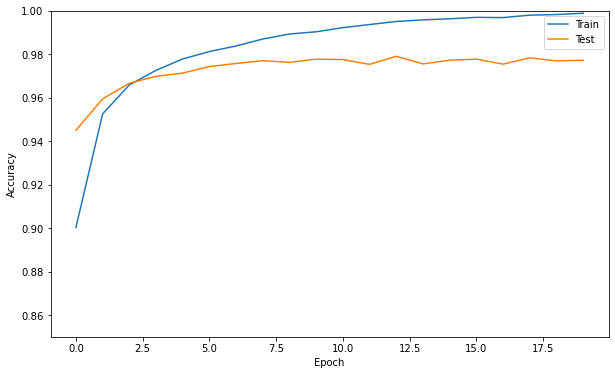

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(history.history['accuracy'], label='Train')
ax.plot(history.history['test acc'], label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_ylim([0.85, 1]);

Since there's the potential to overfit, and a large number of parameters, simply increasing the depth or the width of this network could potentially lead to issues.  Instead of going that route, we will use a different kind of layer in our next notebook that works well for images and introduce convolutional networks, which have become the standard architecture for image data.

# Two points of Comparison: Nearest Neighbor and Random Forest

A bit of truth in advertising, there used to be an 'sklearn' version of k nearest neighbors in this notebook. However, it was so slow to run that it got annoying.  Now there is a supplemental notebook

module05_03a_faiss_knn_mnist

That is best place to go and see an alternative - and fast - k nearest neighbors solution to MNIST.  Note that for $k = 3$ the accuracy on the test data is $0.9705$. 


The other method is called a Random Forest and we retain it here in Fall 2021 even though it is a technique that comes later in the semester. 

### Random Forest on MNIST

In [26]:
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=8)
rf.fit(X_train_flat, y_train);

In [28]:
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_test_flat)
accuracy_score(y_pred, y_test)

0.9375

### Comments

The resources availble online to help visualize and understand these concepts are vast, and here is just one example directly related MNIST.  You might enjoy:

- [Neural Network 3D Simulation](https://youtu.be/3JQ3hYko51Y)

There are major issues in using feed-forward neural networks for image classification:

* Fully connected networks can have very large numbers of parameters with increasing image sizes.  Consider for example images of size 228x228x3, which is standard in this field.  Using the network architecture we have here would result in 228\*228\*3\*100 parameters from the input to the hidden layer - about 15,000,000.  This network would also not be successful - we would need to significantly increase the width and depth, compounding the issue.  It is likely that billions of parameters would be necessary to achieve good accuracy.
* If we take an image that represents the number seven, and shift the seven over a few pixels, we would expect it to still be classified as a seven.  However, fully connected networks are not able to represent this invariance.

Some of these concerns apply to other standard machine learning approaches as well.
Convolutional networks which are introduced next, address these shortcomings, and have led to major improvements in accuracy in image classification tasks.  Their success has led to a renaissance of the field of neural networks.